In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
## Load dataset
data_path = "../../../rings_varying_radius_c2k"
Data = torch.from_numpy(np.load(data_path + '/obs.npy')).float()
NUM_DATASETS, N, D = Data.shape
K = 3 ## number of clusters
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 8
NUM_HIDDEN_LOCAL = 64
NUM_STATS = 16

MCMC_SIZE = 10
BATCH_SIZE = 20
NUM_EPOCHS = 250
LEARNING_RATE = 1e-3

CUDA = torch.cuda.is_available()
PATH = 'ep-rad-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

noise_sigma = torch.ones(1) * 0.05
if CUDA:
    noise_sigma = noise_sigma.cuda().to(DEVICE)
Train_Params = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE, CUDA, DEVICE, PATH)
Model_Params = (noise_sigma, N, K, D, MCMC_SIZE)

In [3]:
from local_enc import *
from global_oneshot import *
from global_enc import *
## if reparameterize continuous variables
Reparameterized = False
# initialization
oneshot_eta = Oneshot_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
enc_z = Enc_z(K, D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
enc_eta = Enc_mu(K, D, NUM_HIDDEN_GLOBAL, NUM_STATS, CUDA, DEVICE, Reparameterized)
enc_rad = Enc_rad(D, NUM_HIDDEN_LOCAL, CUDA, DEVICE)
if CUDA:
    oneshot_eta.cuda().to(DEVICE)
    enc_z.cuda().to(DEVICE)
    enc_eta.cuda().to(DEVICE)
    enc_rad.cuda().to(DEVICE)

optimizer =  torch.optim.Adam(list(enc_rad.parameters())+list(oneshot_eta.parameters())+list(enc_eta.parameters())+list(enc_z.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))
models = (oneshot_eta, enc_eta, enc_z, enc_rad)

In [4]:
# enc_rad.load_state_dict(torch.load("../weights/enc-rad-%s" % PATH))
# enc_z.load_state_dict(torch.load("../weights/enc-z-%s" % PATH))
# enc_eta.load_state_dict(torch.load("../weights/enc-mu-%s" % PATH))
# oneshot_eta.load_state_dict(torch.load("../weights/oneshot-mu-%s" % PATH))

In [5]:
from ag_ep_rad import *
train(models, EUBO_init_eta, optimizer, Data, Model_Params, Train_Params)

epoch: 0\250 (20s),  DB_eta: 106038.855,  DB_z: 97368.177,  DB_rad: 374198.132,  gap_eta: 106046.430,  gap_z: 96667.707,  gap_rad: 373910.910,  loss: -96877.499,  ess: 1.921
epoch: 1\250 (19s),  DB_eta: 24124.101,  DB_z: 38000.588,  DB_rad: 163958.603,  gap_eta: 24142.267,  gap_z: 37617.740,  gap_rad: 163744.270,  loss: -19163.231,  ess: 2.068
epoch: 2\250 (19s),  DB_eta: 1382.897,  DB_z: 5219.977,  DB_rad: 24405.858,  gap_eta: 1419.780,  gap_z: 4881.690,  gap_rad: 24121.231,  loss: -4378.157,  ess: 2.270
epoch: 3\250 (19s),  DB_eta: 306.803,  DB_z: 1294.107,  DB_rad: 10590.017,  gap_eta: 358.970,  gap_z: 1042.200,  gap_rad: 10330.144,  loss: -3630.460,  ess: 2.826
epoch: 4\250 (19s),  DB_eta: 123.373,  DB_z: 421.636,  DB_rad: 6732.209,  gap_eta: 182.676,  gap_z: 318.105,  gap_rad: 6557.472,  loss: -3539.805,  ess: 3.533
epoch: 5\250 (19s),  DB_eta: 65.255,  DB_z: 209.529,  DB_rad: 4476.803,  gap_eta: 131.201,  gap_z: 176.674,  gap_rad: 4335.270,  loss: -3500.521,  ess: 3.995
epoch: 6\

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/hao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-2314f64dca9b>", line 2, in <module>
    train(models, EUBO_init_eta, optimizer, Data, Model_Params, Train_Params)
  File "../training.py", line 24, in train
    loss, metric_step, reused = objective(models, obs, SubTrain_Params)
  File "../objectives/ag_ep_rad.py", line 44, in EUBO_init_eta
    state, log_w_z_f, log_w_z_b = Incremental_z(q_z, p_z, obs, obs_mu, rad, noise_sigma, K, D, state)
  File "../forward_backward_rad.py", line 55, in Incremental_z
    log_obs = True_Log_likelihood_rad(obs, state, obs_mu, rad, noise_sigma, cluster_flag=False)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/hao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 

KeyboardInterrupt: 

In [13]:
torch.save(enc_rad.state_dict(), "../weights/enc-rad-%s" % PATH)
torch.save(enc_z.state_dict(), "../weights/enc-z-%s" % PATH)
torch.save(enc_eta.state_dict(), "../weights/enc-mu-%s" % PATH)
torch.save(oneshot_eta.state_dict(), "../weights/oneshot-mu-%s" % PATH)

In [14]:
optimizer2 =  torch.optim.Adam(list(enc_rad.parameters())+list(oneshot_eta.parameters())+list(enc_eta.parameters())+list(enc_z.parameters()),lr= 1e-4, betas=(0.9, 0.99))
Model_Params = (noise_sigma, N, K, D, 20)
train(models, EUBO_init_eta, optimizer2, Data, Model_Params, Train_Params)

epoch: 0\250 (38s),  DB_eta: 19.092,  DB_z: 15.840,  DB_rad: 449.946,  gap_eta: 73.015,  gap_z: 69.020,  gap_rad: 372.389,  loss: -2881.005,  ess: 6.110
epoch: 1\250 (38s),  DB_eta: 18.159,  DB_z: 14.667,  DB_rad: 449.717,  gap_eta: 72.615,  gap_z: 68.765,  gap_rad: 374.768,  loss: -2879.539,  ess: 6.145
epoch: 2\250 (38s),  DB_eta: 18.395,  DB_z: 15.308,  DB_rad: 460.621,  gap_eta: 73.186,  gap_z: 69.254,  gap_rad: 384.941,  loss: -2875.067,  ess: 6.124
epoch: 3\250 (38s),  DB_eta: 17.867,  DB_z: 14.798,  DB_rad: 473.328,  gap_eta: 72.356,  gap_z: 69.223,  gap_rad: 398.311,  loss: -2871.453,  ess: 6.138
epoch: 4\250 (38s),  DB_eta: 17.470,  DB_z: 14.247,  DB_rad: 486.845,  gap_eta: 72.634,  gap_z: 69.234,  gap_rad: 411.654,  loss: -2866.596,  ess: 6.140
epoch: 5\250 (38s),  DB_eta: 17.856,  DB_z: 14.665,  DB_rad: 503.128,  gap_eta: 72.987,  gap_z: 69.885,  gap_rad: 427.460,  loss: -2860.768,  ess: 6.118
epoch: 6\250 (38s),  DB_eta: 17.726,  DB_z: 14.892,  DB_rad: 513.222,  gap_eta: 72

KeyboardInterrupt: 

In [15]:
from ag_ep_rad import *

BATCH_SIZE_TEST = 25
Train_Params_Test = (NUM_EPOCHS, NUM_DATASETS, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, PATH)
Model_Params_Test = (noise_sigma, N, K, D, 20)
obs, metric_step, reused = test(models, EUBO_init_eta, Data, Model_Params_Test, Train_Params_Test)
(q_mu, _, q_z, _, q_rad, _) = reused

CPU times: user 1.27 s, sys: 4.09 ms, total: 1.28 s
Wall time: 1.28 s


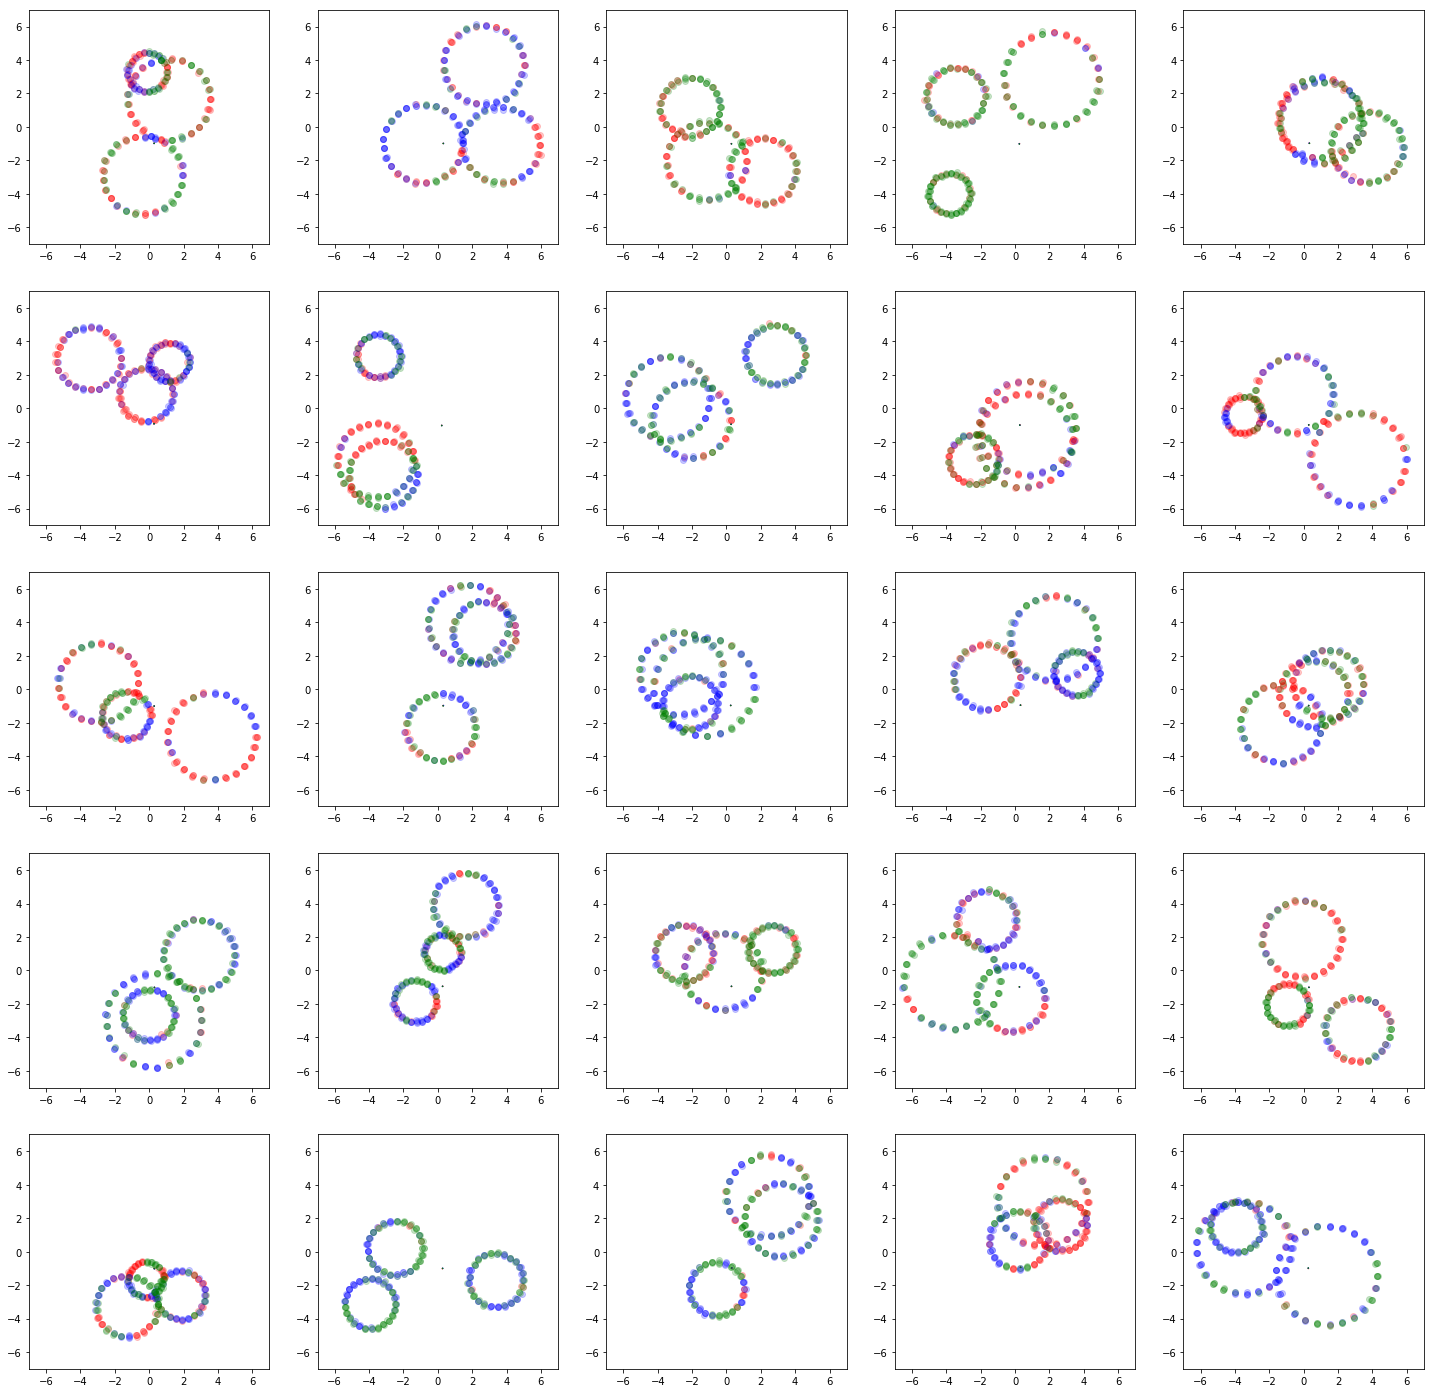

In [16]:
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [ ]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')